In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/OpenImages/train.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/train/plant/labels/02d2a1303ca70af9.txt  
 extracting: /content/train/plant/labels/02d3cca46dce1437.txt  
  inflating: /content/train/plant/labels/02d40e7a83d908e6.txt  
  inflating: /content/train/plant/labels/02d51a81bdd2e0a7.txt  
  inflating: /content/train/plant/labels/02d5614ad60f218e.txt  
 extracting: /content/train/plant/labels/02d5982e2c17837c.txt  
 extracting: /content/train/plant/labels/02d5a040896342c5.txt  
 extracting: /content/train/plant/labels/02d6a73ec13c76d7.txt  
 extracting: /content/train/plant/labels/02d72be793ae5bb4.txt  
 extracting: /content/train/plant/labels/02d74d7e6e3bf01b.txt  
  inflating: /content/train/plant/labels/02d796de59e022cf.txt  
  inflating: /content/train/plant/labels/02d86bd2214be18c.txt  
  inflating: /content/train/plant/labels/02d94e769939e271.txt  
  inflating: /content/train/plant/labels/02d9f9fd29b820d5.txt  
 extracting: /content/train/plant/labels/02dd5fff0390

In [3]:
!unzip "/content/drive/MyDrive/OpenImages/test.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/test/boat/0419f1476a7ff3ba.jpg  
 extracting: /content/test/boat/042eaf600f7d2d89.jpg  
  inflating: /content/test/boat/0430b0b5678b8129.jpg  
  inflating: /content/test/boat/047a6615b8f58d4b.jpg  
  inflating: /content/test/boat/04c96ce577b79243.jpg  
  inflating: /content/test/boat/04e0964c06156a89.jpg  
  inflating: /content/test/boat/051d7be70ecbda36.jpg  
  inflating: /content/test/boat/05207c3f65db7b90.jpg  
  inflating: /content/test/boat/053164834b735760.jpg  
  inflating: /content/test/boat/0540c5d031611551.jpg  
  inflating: /content/test/boat/0543fc451dad39b6.jpg  
  inflating: /content/test/boat/0551ef1d3b60a1ca.jpg  
  inflating: /content/test/boat/05661687100e9e02.jpg  
 extracting: /content/test/boat/057bce56bfbbf5d6.jpg  
 extracting: /content/test/boat/05cfc55b16cc2b14.jpg  
  inflating: /content/test/boat/067b5a0af919aab7.jpg  
 extracting: /content/test/boat/068d8e12553a71ae.jpg  
 extracting: /

In [4]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from imutils import paths
from tqdm.notebook import tqdm as tqdm
# import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import imutils
import pickle
import cv2
import os
# import xml.etree.ElementTree as ET

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
  # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
trainData, valData, testData = [], [], []
# trainLabels, valLabels, testLabels = [], [], []
# trainBBoxes, valBBoxes, testBBoxes = [], [], []
# trainImagePaths, valImagePaths, testImagePaths = [], [], []

In [7]:
trainSize = 2000
valSize = 500
testSize = 500

# Обучение сети

### Чтение данных

In [8]:
train_dir = "/content/train"
dirs = [f.path for f in os.scandir(train_dir) if f.is_dir()]
for dir in tqdm(dirs):
    files = [f.path for f in os.scandir(dir) if f.is_file()]
    for path in tqdm(files[:trainSize]):
        filename = os.path.basename(os.path.normpath(path))
        image = cv2.imread(path)
        (h, w) = image.shape[:2]
        label_filename = os.path.splitext(filename)[0] + ".txt"
        rows = open(os.path.join(dir, "labels", label_filename)).read().strip().split("\n")
        for row in rows:
          (label, startX, startY, endX, endY) = row.split(" ")
          startX = float(startX) / w
          startY = float(startY) / h
          endX = float(endX) / w
          endY = float(endY) / h
          trainData.append([path, label, (startX, startY, endX, endY)])

In [9]:
train_df = pd.DataFrame(trainData, columns = ['filename', 'label', "bbox"])
train_df.head()

,filename,label,bbox
0,/content/train/horse/093af6dabac02d78.jpg,horse,"(0.335625, 0.260745, 0.72625, 0.8739259999999999)"
1,/content/train/horse/093af6dabac02d78.jpg,horse,"(0.77, 0.276982, 0.920625, 0.858644)"
2,/content/train/horse/2b968b1868648b0c.jpg,horse,"(0.191875, 0.361667, 0.615625, 0.760833)"
3,/content/train/horse/220af95a960254d2.jpg,horse,"(0.0, 0.41176500000000005, 0.655625, 0.9990660..."
4,/content/train/horse/220af95a960254d2.jpg,horse,"(0.5675, 0.413632, 0.999375, 0.9990660000000001)"


In [10]:
test_dir = "/content/test"
dirs = [f.path for f in os.scandir(test_dir) if f.is_dir()]
for dir in tqdm(dirs):
    files = [f.path for f in os.scandir(dir) if f.is_file()]
    for path in tqdm(files[:testSize]):
        filename = os.path.basename(os.path.normpath(path))
        image = cv2.imread(path)
        (h, w) = image.shape[:2]
        label_filename = os.path.splitext(filename)[0] + ".txt"
        rows = open(os.path.join(dir, "labels", label_filename)).read().strip().split("\n")
        for row in rows:
          (label, startX, startY, endX, endY) = row.split(" ")
          startX = float(startX) / w
          startY = float(startY) / h
          endX = float(endX) / w
          endY = float(endY) / h
          testData.append([path, label, (startX, startY, endX, endY)])

In [11]:
test_df = pd.DataFrame(testData, columns = ['filename', 'label', "bbox"])
test_df.head()

,filename,label,bbox
0,/content/test/horse/3e48ec08bb56cdd9.jpg,horse,"(0.059158135, 0.24355301, 0.41865757, 0.9426934)"
1,/content/test/horse/441d7c7ab95f7c36.jpg,horse,"(0.32253313, 0.19290465, 0.6848306, 0.98226166..."
2,/content/test/horse/441d7c7ab95f7c36.jpg,horse,"(0.32253313, 0.19290465, 1.0, 0.9800443599999998)"
3,/content/test/horse/441d7c7ab95f7c36.jpg,horse,"(0.82474226, 0.50110865, 1.0, 0.8736142)"
4,/content/test/horse/2cb3fb029c46b5cb.jpg,horse,"(0.43125, 0.7395833, 0.58125, 0.85833335)"


In [12]:
train_labels = train_df['label'].unique()
test_labels = test_df['label'].unique()
labels = np.concatenate((test_labels, train_labels), axis=0)
labels = np.unique(labels)
labels

array(['boat', 'car', 'cat', 'dog', 'fish', 'fruit', 'glasses', 'horse',
       'plant', 'sculpture'], dtype=object)

In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
if len(lb.classes_) == 2:
  labels = to_categorical(labels)

In [14]:
onehotencoding = dict(zip(lb.classes_, labels))
onehotencoding

{'boat': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'car': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'cat': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'dog': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'fish': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'fruit': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'glasses': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'horse': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'plant': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'sculpture': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [15]:
class CustomDataGen(Sequence):
    
    def __init__(self, df, X_col, y_col, label_encoding,
                 batch_size=32,
                 input_size=(224, 224, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.label_encoding = label_encoding
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
            
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
    
        image = load_img(path, target_size=(224, 224))
        image_arr = img_to_array(image)

        return image_arr/255.0
    
    def __get_label(self, label, encoding):
        # return to_categorical(label, num_classes=num_classes)
        return encoding[label]
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['filename']]
        
        label_batch = batches[self.y_col['label']]
        bbox_batch = batches[self.y_col['bbox']]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch])

        y_labels = np.asarray([self.__get_label(y, self.label_encoding) for y in label_batch])
        y_BBoxes = np.asarray([y for y in bbox_batch])

        y_batch = {"class_label": y_labels,"bounding_box": y_BBoxes}

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [16]:
batch_size = 32

In [17]:
train_data_gen = CustomDataGen(
                              train_df,
                              X_col = {"filename" : "filename"},
                              y_col = {"label" : "label", "bbox" : "bbox"},
                              label_encoding = onehotencoding,
                              batch_size = batch_size,
                              )

In [18]:
test_data_gen = CustomDataGen(
                              test_df,
                              X_col = {"filename" : "filename"},
                              y_col = {"label" : "label", "bbox" : "bbox"},
                              label_encoding = onehotencoding,
                              batch_size = batch_size
                              )

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
# trainData = np.array(trainData, dtype="float32") / 255.0
# trainLabels = np.array(trainLabels)
# trainBBoxes = np.array(trainBBoxes, dtype="float32")
# trainImagePaths = np.array(trainImagePaths)

# valData = np.array(valData, dtype="float32") / 255.0
# valLabels = np.array(valLabels)
# valBBoxes = np.array(valBBoxes, dtype="float32")
# valImagePaths = np.array(valImagePaths)

# testData = np.array(testData, dtype="float32") / 255.0
# testLabels = np.array(testLabels)
# testBBoxes = np.array(testBBoxes, dtype="float32")
# testImagePaths = np.array(testImagePaths)

# perform one-hot encoding on the labels
# lb = LabelBinarizer()
# trainLabels = lb.fit_transform(trainLabels)
# if len(lb.classes_) == 2:
# 	trainLabels = to_categorical(trainLabels)
 
# valLabels = lb.fit_transform(valLabels)
# if len(lb.classes_) == 2:
# 	valLabels = to_categorical(valLabels)
 
# testLabels = lb.fit_transform(testLabels)
# if len(lb.classes_) == 2:
# 	testLabels = to_categorical(testLabels)

In [19]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58892288/58889256 [==============================] - 0s 0us/step


In [20]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead) #0.5
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead) #0.5
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [21]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"],
    loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# construct a dictionary for our target training outputs
# trainTargets = {
# 	"class_label": trainLabels,
# 	"bounding_box": trainBBoxes
# }

# construct a second dictionary, this one for our target testing
# outputs
# testTargets = {
# 	"class_label": testLabels,
# 	"bounding_box": testBBoxes
# }

In [22]:
checkpoint_filepath="/content/drive/MyDrive/image-finder/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)

In [23]:
class save_lb_callback(Callback):

    def __init__(self, lb):
        super()
        self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
      print("[INFO] saving label binarizer...")
      label_path = os.path.sep.join(["/content/drive/MyDrive/image-finder", f"lb-ep{epoch}.pickle"])
      f = open(label_path, "wb")
      f.write(pickle.dumps(self.lb))
      f.close()


In [24]:
saveLB = save_lb_callback(lb)

In [25]:
print("[INFO] training model...")
# H = model.fit(
# 	trainData, trainTargets,
# 	validation_data=(testData, testTargets),
# 	batch_size=32,
# 	epochs=20,
# 	verbose=1)

# H = model.fit(
# 	trainData, trainTargets,
# 	validation_data=(testData, testTargets),
# 	batch_size=32,
# 	epochs=8,
# 	verbose=1)

# Fit the model
H = model.fit(
	train_data_gen,
	validation_data = test_data_gen,
	steps_per_epoch = train_df.shape[0] // batch_size,
  validation_steps = test_df.shape[0] // batch_size,
	epochs=15,
  use_multiprocessing = True,
	verbose=1,
  callbacks=[model_checkpoint_callback, saveLB],
  workers = 2,
  validation_freq = 2)

[INFO] training model...
Epoch 1/15
1680/1680 [==============================] - 700s 394ms/step - loss: 1.7126 - bounding_box_loss: 0.0645 - class_label_loss: 1.6481 - bounding_box_accuracy: 0.5555 - class_label_accuracy: 0.4336
[INFO] saving label binarizer...
Epoch 2/15
1680/1680 [==============================] - 712s 423ms/step - loss: 1.2169 - bounding_box_loss: 0.0600 - class_label_loss: 1.1569 - bounding_box_accuracy: 0.5817 - class_label_accuracy: 0.6143 - val_loss: 1.1278 - val_bounding_box_loss: 0.0651 - val_class_label_loss: 1.0627 - val_bounding_box_accuracy: 0.5792 - val_class_label_accuracy: 0.6431
[INFO] saving label binarizer...
Epoch 3/15
1680/1680 [==============================] - 645s 383ms/step - loss: 1.0053 - bounding_box_loss: 0.0580 - class_label_loss: 0.9472 - bounding_box_accuracy: 0.5953 - class_label_accuracy: 0.6896
[INFO] saving label binarizer...
Epoch 4/15
1680/1680 [==============================] - 710s 422ms/step - loss: 0.8670 - bounding_box_loss: 

In [26]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model_path = os.path.sep.join(["/content/drive/MyDrive/image-finder", "detector-20210530.h5"])
model.save(model_path, save_format="h5")

[INFO] saving object detector model...


In [27]:
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
label_path = os.path.sep.join(["/content/drive/MyDrive/image-finder", "lb-20210530.pickle"])
f = open(label_path, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label binarizer...


In [ ]:
# model_path = os.path.sep.join(["/content/drive/MyDrive/image-finder", "detector-20210530.h5"])
# model = tf.keras.models.load_model(model_path)
# model.summary()

In [33]:
np.linspace(2, 14, 7)

array([ 2.,  4.,  6.,  8., 10., 12., 14.])

In [35]:
H.history["val_loss"]

[1.1278249025344849,
 1.1029287576675415,
 1.2398476600646973,
 1.148655652999878,
 1.2665081024169922,
 1.137250304222107,
 1.2430949211120605]

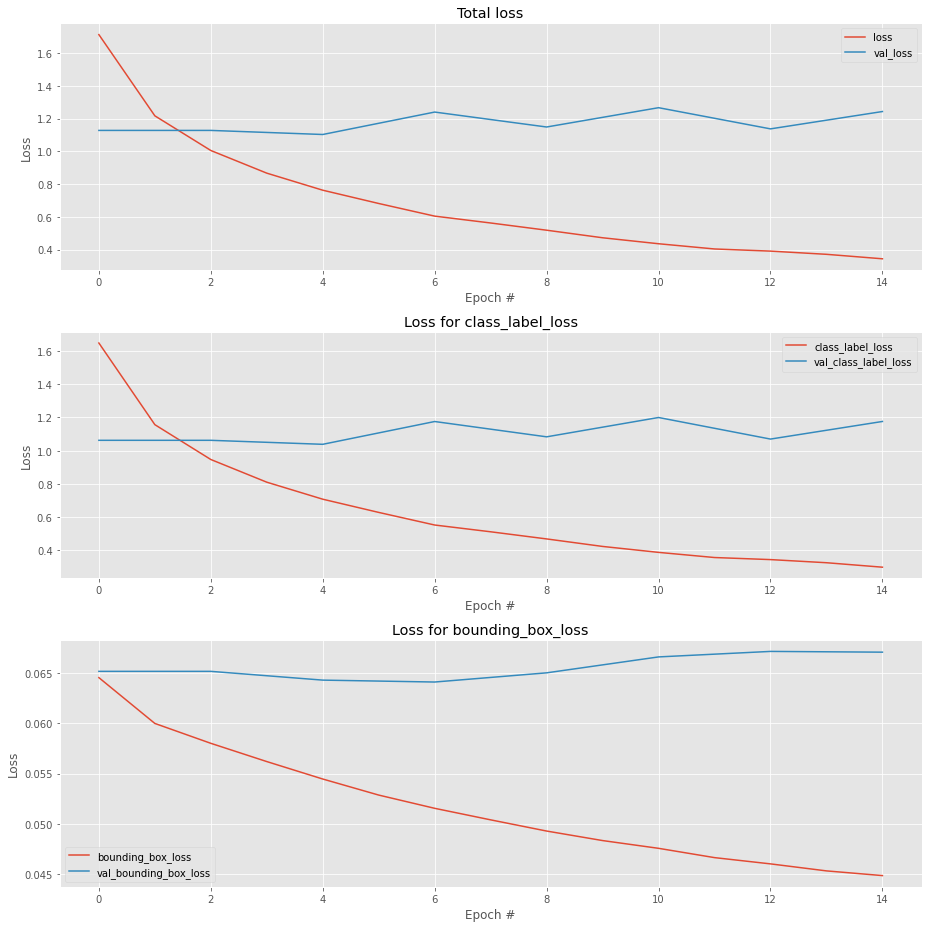

In [34]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 15)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, np.interp(N, np.linspace(2, 14, 7), H.history["val_" + l]), label="val_" + l)
	ax[i].legend()

# display the plot
plt.tight_layout()
plt.show()

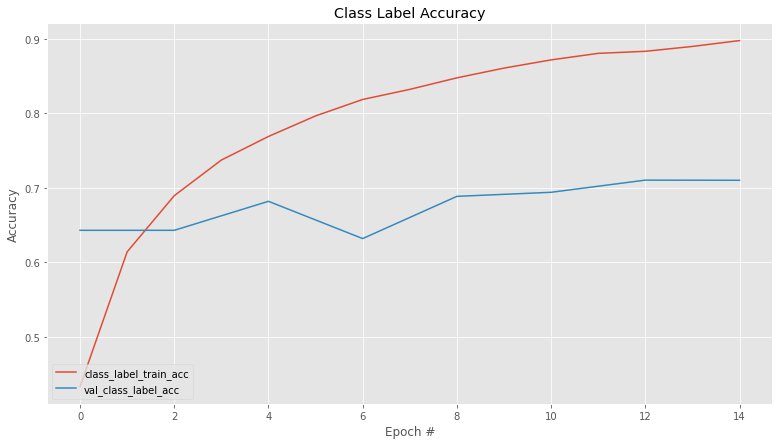

In [37]:
plt.style.use("ggplot")
plt.figure(figsize=(13, 7))
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, np.interp(N, np.linspace(2, 14, 7), H.history["val_class_label_accuracy"]),
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# display the plot
plt.show()

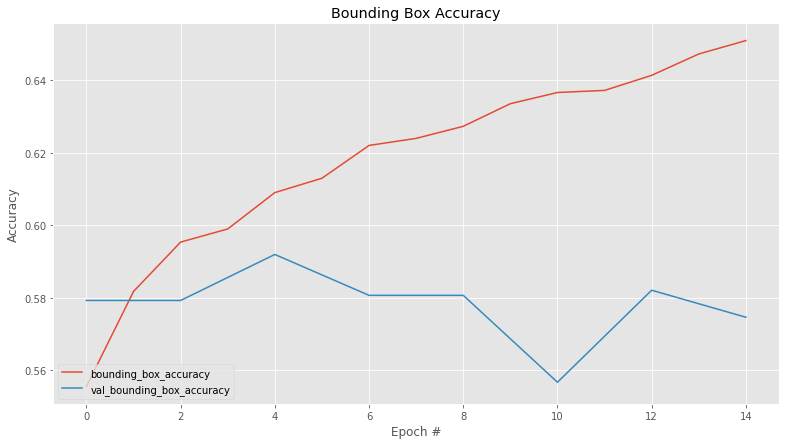

In [38]:
plt.style.use("ggplot")
plt.figure(figsize=(13, 7))
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, np.interp(N, np.linspace(2, 14, 7), H.history["val_bounding_box_accuracy"]),
	label="val_bounding_box_accuracy")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# display the plot
plt.show()

In [39]:
model.save_weights("/content/drive/MyDrive/image-finder/weights-20210530.h5")